In [1]:
import os, sys 
from pathlib import Path
from os.path import dirname, realpath
script_dir = Path(dirname(realpath('.')))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
import numpy as np
import utility as ut
import matplotlib.pyplot as plt
import pandas as pd
import glob, json
from scipy import stats
import seaborn as sns
import oneshot as sm
import rfm, skipRFM, localRFM, localSkip, deepSkip, deepRFM, localDeepRFM, localDeepSkip
# import parallel_euler as arch1
import torch, time
from torch import nn
import config
# warnings.filterwarnings('ignore'

dynamical_system = 'KS'
L = 22
# Uo = torch.tensor(np.load(f'../data/{dynamical_system}/train.npy'))[:,:100000]
# Vo = torch.tensor(np.load(f'../data/{dynamical_system}/test.npy'))
Uo = torch.tensor(np.load(f'../data/{dynamical_system}-{L}/train.npy'))[:,:100000]
Vo = torch.tensor(np.load(f'../data/{dynamical_system}-{L}/test.npy'))
# Uo = torch.tensor(ks0.ks32(dt=0.01, tmax=300)[:, 4000:-1000])
noise =  0.001*torch.randn(size=Uo.shape)
Uon = Uo + noise

L0, L1 = 0.4, 3.5
D, D_r, B = 3, 2048, 1
beta = 1e-5
data_folder = '../data'
G, I = 8,1                                                                                         

drf_args = [D_r, 1, L0, L1, Uo, beta, 'LocalSkip', f'{data_folder}/temp/localSkipKS/depth-{B}', False, G, I]
b = localSkip.BatchDeepRF(Uo, Vo, *drf_args)
start = time.time()
b.drf.learn(Uo, 42)

print(torch.linalg.cond(Uo))
# bn = localSkip.BatchDeepRF(Uo, Vo, *drf_args)
# bn.drf.learn(Uon, 42)
# end = time.time()

# print(f"Time taken = {end-start}s")
# kwargs = {200:{'error_threshold': 0.25, 'dt': 0.25, 'Lyapunov_time': 1/0.094},\
#           22:{'error_threshold' : 0.25, 'dt': 0.25, 'Lyapunov_time': 1/0.043},\
#           12:{'error_threshold' : 0.25, 'dt': 0.25, 'Lyapunov_time': 1/0.003},\
#          '13_5':{'error_threshold' : 0.25, 'dt': 0.25, 'Lyapunov_time': 1/0.059},\
#          '200-001':{'error_threshold': 0.25, 'dt': 0.001, 'Lyapunov_time': 1/0.094},}
# # kwargs = {200:{'error_threshold': 0.25, 'dt': 0.01, 'Lyapunov_time': 1/2.27}}
# print(b.drf.compute_tau_f(Vo[:10], **kwargs[L])[0].mean())
# print(bn.drf.compute_tau_f(Vo[:10], **kwargs[L])[0].mean())

# @ut.timer
# def get_eval(batch):
#     eval = torch.zeros_like(Uo.T)
#     j = 0
#     for i in range(10):
#         eval[j:j+10000] = batch.drf.forecast(Uo.T[j:j+10000])
#         j += 10000
#     return eval

tensor(9.6269e+14)


**Look at loss**

In [2]:
X = Uo.T[:-1][..., b.drf.net.idx][:, b.drf.net.Ng//2, :]
Y = (Uo.T[1:] - Uo.T[:-1])[..., b.drf.net.idy][:, b.drf.net.Ng//2, :]

Xn = Uon.T[:-1][..., bn.drf.net.idx][:, bn.drf.net.Ng//2, :]
Yn = (Uon.T[1:] - Uon.T[:-1])[..., bn.drf.net.idy][:, bn.drf.net.Ng//2, :]

phi = torch.tanh(b.drf.net.inner[0](X)).detach()
phin = torch.tanh(bn.drf.net.inner[0](Xn)).detach()
phin_ = torch.tanh(bn.drf.net.inner[0](X)).detach()

Yphi = Y.T@phi
Yphin = Yn.T@phin

# eval = torch.tensor(np.load('../data/temp/eval.npy'))
# evaln = torch.tensor(np.load('../data/temp/evaln.npy'))

w = torch.sqrt((b.drf.net.outer[0].weight.detach()**2).sum())
wn = torch.sqrt((bn.drf.net.outer[0].weight.detach()**2).sum())
print(w, wn)

loss = ((b.drf.net.outer[0](phi) - Y)**2).sum() #+ beta*w**2
lossn = ((bn.drf.net.outer[0](phin) - Yn)**2).sum() #+ beta*wn**2
lossn_ = ((bn.drf.net.outer[0](phin_) - Y)**2).sum()
print(loss, lossn, lossn_)

tensor(213.0596) tensor(213.6676)
tensor(0.4049, grad_fn=<SumBackward0>) tensor(1.5891, grad_fn=<SumBackward0>) tensor(0.5364, grad_fn=<SumBackward0>)


**Condition number of the invertible matrix**

In [28]:
a0 = phi.T@phi
a = a0 + beta*torch.eye(D_r)

a0n = phin.T@phin 
an = a0n + beta*torch.eye(D_r)

print(np.linalg.det(a0n), torch.linalg.det(an))


con = torch.linalg.cond(a)
conn = torch.linalg.cond(an)

print(con, conn)

0.0 tensor(0.)
tensor(1.6485e+13) tensor(1.6487e+13)


In [29]:
torch.linalg.cond(a0), torch.linalg.cond(a0n)

(tensor(3.3752e+19), tensor(7.6157e+18))

**Distribution of entries of W**

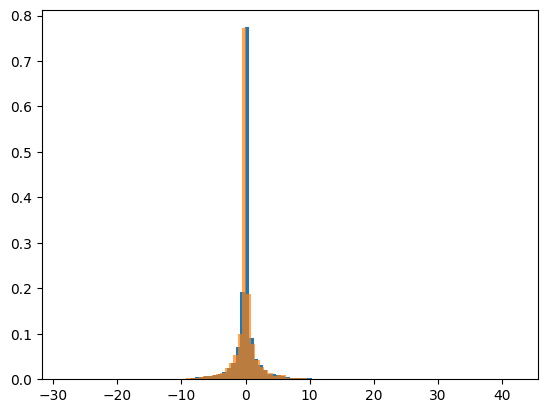

In [6]:
W = b.drf.net.outer[0].weight.detach().numpy()
Wn = bn.drf.net.outer[0].weight.detach().numpy()
plt.hist(W.flatten(), bins=100, density=True)
plt.hist(Wn.flatten(), bins=100, alpha=0.7, density=True)
plt.savefig('../data/plots/W-dist.png')

**Look at predicted trajectories**

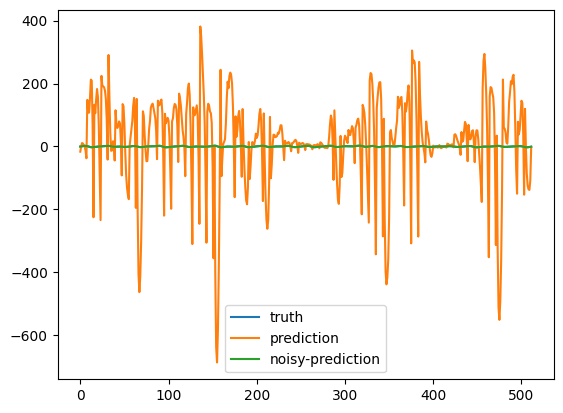

In [7]:
n = 100
v = Vo[0][:, :n]
vh = b.drf.multistep_forecast(v[:, 0], n)
vhn = bn.drf.multistep_forecast(v[:, 0], n)
plt.plot(v[:, 20], label='truth')
plt.plot(vh[:, 20], label='prediction')
plt.plot(vhn[:, 20], label='noisy-prediction')
plt.legend()

In [8]:
np.linalg.cond(W), np.linalg.cond(Wn), np.linalg.cond(a0), np.linalg.cond(a0n), np.linalg.cond(Yphi), np.linalg.cond(Yphin)

(1329.0411806335621,
 11.913957374151915,
 2.5691229591189725e+19,
 1.3683178003578534e+20,
 226964.51394674115,
 16459.364687376154)

In [47]:
np.linalg.cond(Y[:10000]), np.linalg.cond(Yn[:8])

(17265.3529857055, 2374.8259858072793)

In [39]:
np.linalg.cond(phi[:100]), np.linalg.cond(phin[:100])

(1.614446268894631e+17, 561053283.9045657)

In [52]:
r = np.random.permutation(len(Y))[:20000]
_, sY, _ = np.linalg.svd(Y[r], full_matrices=True)
_, sYn, _ = np.linalg.svd(Yn[r], full_matrices=True)

In [53]:
sY

array([2.57770093e+01, 2.27483040e+01, 6.87260130e+00, 2.18106917e+00,
       4.38344088e-01, 9.07288728e-02, 1.32492224e-02, 1.53296064e-03])

In [54]:
sYn

array([25.7781748 , 22.74654817,  6.87544929,  2.19179351,  0.47988015,
        0.2191033 ,  0.20156903,  0.20039453])

In [22]:
5136281629698/1e12

5.136281629698

Text(0, 0.5, 'Y[0]')

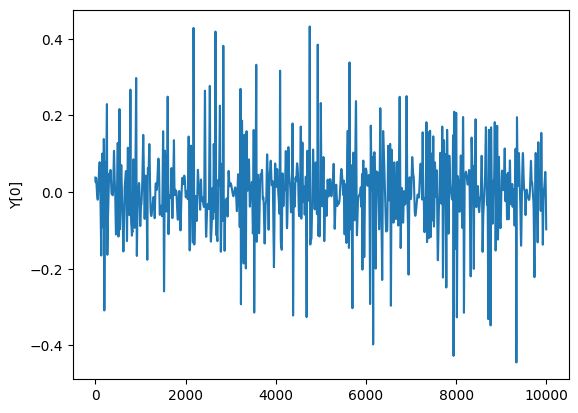

In [171]:
plt.plot(Y[:10000, 0])
plt.ylabel('Y[0]')
# plt.savefig(f'../data/plots/{dynamical_system}_Y.png')

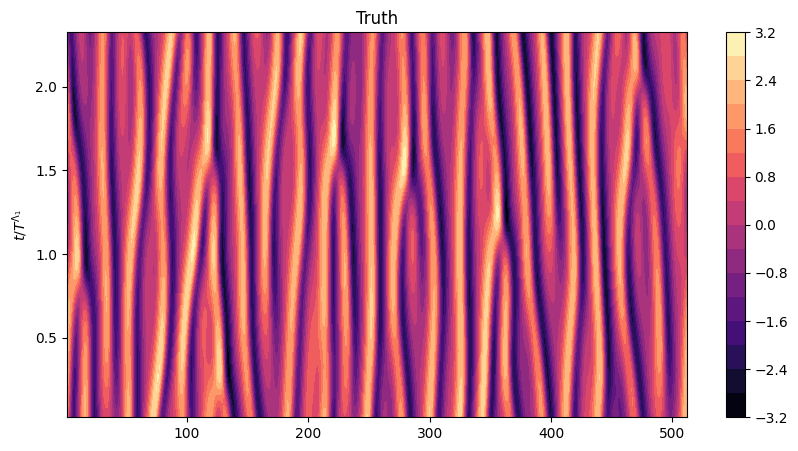

In [216]:
i = 500
ut.waterfall(Uon[:, :99], **kwargs[L])
# ut.waterfall(Yn.T[:, :99], **kwargs[L])

In [73]:
Y.mean(axis=0)

tensor([8.7119e-06, 4.5737e-06, 2.6611e-06, 3.1211e-06, 5.5363e-06, 9.1139e-06,
        1.2799e-05, 1.5384e-05])

In [81]:
np.abs(Y).min()

tensor(8.7171e-08)

(array([1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 2.000e+00, 2.000e+00, 1.000e+01, 7.000e+00, 6.000e+00,
        1.200e+01, 1.200e+01, 1.600e+01, 1.100e+01, 1.900e+01, 1.900e+01,
        3.000e+01, 2.600e+01, 3.000e+01, 3.700e+01, 5.900e+01, 5.800e+01,
        8.400e+01, 8.200e+01, 1.070e+02, 1.280e+02, 1.430e+02, 1.580e+02,
        1.450e+02, 2.070e+02, 2.450e+02, 2.760e+02, 3.800e+02, 4.010e+02,
        4.840e+02, 6.250e+02, 8.260e+02, 9.000e+02, 1.147e+03, 1.597e+03,
        1.879e+03, 2.347e+03, 3.175e+03, 3.992e+03, 4.909e+03, 5.757e+03,
        6.907e+03, 7.601e+03, 8.221e+03, 7.767e+03, 6.921e+03, 5.986e+03,
        4.811e+03, 4.236e+03, 3.362e+03, 2.641e+03, 2.193e+03, 1.673e+03,
        1.279e+03, 1.072e+03, 8.720e+02, 6.520e+02, 5.130e+02, 4.580e+02,
        3.550e+02, 2.890e+02, 2.610e+02, 2.290e+02, 2.330e+02, 1.660e+02,
        1.320e+02, 1.260e+02, 9.500e+01, 1.090e+02, 9.200e+01, 6.900e+01,
        6.200e+01, 5.200e+01, 4.300e+0

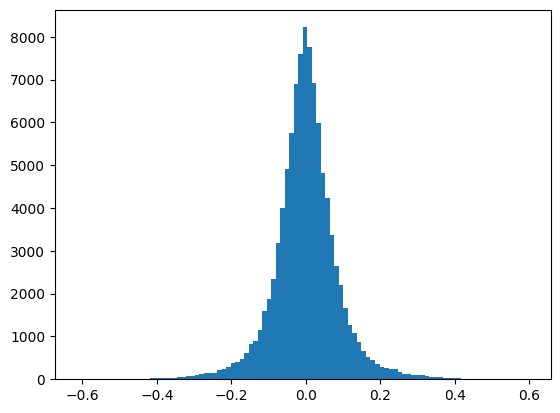

In [169]:
plt.hist(Y[:, 6], bins=100)

In [123]:
x0 = 10**(-2.5) * np.random.normal(size=10)
x1 = 10**2 * np.random.normal(size=10)
x2 = 10**(-1.5) * np.random.normal(size=10)
x3 = 10**(-1) * np.random.normal(size=10)
x4 = 10**(-0.5) * np.random.normal(size=10)
x5 = np.random.normal(size=10)

w = np.vstack((x0,  x5)) 
np.linalg.svd(w, full_matrices=True)[1]

array([4.34983042, 0.00899727])

In [128]:
x, y = Y[np.argmax(n)], Y[np.argmin(n)]

xy = np.dot(x, y)
xm = n[np.argmax(n)]
ym = n[np.argmin(n)]
sin = np.sqrt(1 - (xy / xm*ym)**2) 

est = 1/((ym/xm) * sin)

In [127]:
p, q = np.linalg.norm(x5), np.linalg.norm(x0)

np.linalg.cond(w), (p/q) / np.sqrt(1 - (np.dot(x0, x5) / (p*q))**2)

(483.4608724322203, 483.46066642032537)

In [176]:
n = np.linalg.norm(Y, axis=1)
nn = np.linalg.norm(Yn, axis=1)
n.max()/n.min()

603.0137914390381

In [129]:
est

603.0137914391486

(array([  1.,   0.,   0.,   1.,   0.,   0.,   1.,   2.,   1.,   0.,   1.,
          1.,   4.,   5.,   8.,  10.,   4.,   6.,   7.,  14.,  12.,  16.,
         14.,  15.,  13.,  19.,  20.,  16.,  21.,  22.,  33.,  20.,  29.,
         33.,  41.,  47.,  48.,  54.,  61.,  64.,  55.,  72.,  73.,  84.,
         87.,  91.,  98., 121., 140., 179., 197., 200., 202., 172., 192.,
        216., 239., 234., 279., 250., 299., 261., 243., 289., 298., 269.,
        308., 266., 228., 216., 242., 246., 255., 249., 259., 251., 272.,
        200., 172., 168., 157., 133., 121.,  99.,  88., 103.,  81.,  65.,
         61.,  64.,  41.,  45.,  33.,  19.,  13.,  12.,  11.,   9.,   3.,
          6.]),
 array([-2.31926371, -2.29553338, -2.27180305, -2.24807272, -2.22434239,
        -2.20061206, -2.17688173, -2.1531514 , -2.12942107, -2.10569074,
        -2.08196041, -2.05823008, -2.03449975, -2.01076942, -1.98703909,
        -1.96330876, -1.93957843, -1.9158481 , -1.89211777, -1.86838744,
        -1.84465711, -1.82

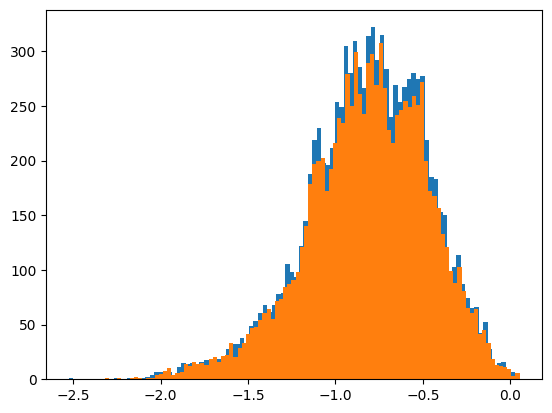

In [194]:
plt.hist(np.log10(n[:10000]), bins=100)
plt.hist(np.log10(nn[:10000]), bins=100)

In [170]:
k = 10000
v = np.linspace(-0.4, 0.4, num=8)
M = n.mean() * np.random.normal(size=(8, k)) / 2.74
M_ = M * 10**v[:, None]
np.linalg.cond(M), np.linalg.cond(M_)

(1.053608998847286, 6.248322018792303)

In [166]:
np.linalg.svd(M)[1], np.linalg.svd(M_)[1],

(array([7.4102127 , 7.29256485, 7.27133652, 7.22276066, 7.19353335,
        7.13384053, 7.09269284, 7.08708757]),
 array([7.2056038 , 3.19300887, 1.3874832 , 0.61369219, 0.26942403,
        0.11747926, 0.05215036, 0.02263963]))

In [154]:
10**(2.5)

316.22776601683796

In [158]:
10**1.1

12.589254117941675

In [157]:
10**0.3

1.9952623149688795

In [164]:
n.mean()

0.19767532205126973

In [174]:
np.abs(Y[0]).min()

tensor(0.0045)

In [179]:
10**(-2.5)

0.0031622776601683794

In [182]:
np.log10(np.sqrt(2)*0.01*2.74)

-1.4117344393476212

In [189]:
torch.linalg.cond(Y[np.log10(n) > -0.1][:10000])

tensor(39044.1927)

In [200]:
np.linalg.norm(Uo, axis=0).shape

(100000,)

In [205]:
torch.linalg.cond(Uo.T[:10000])

tensor(2.2696e+15)

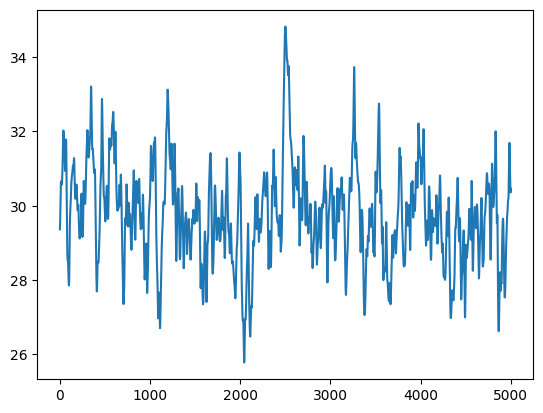

In [213]:
plt.plot(np.linalg.norm(Uo, axis=0)[:5000])

In [207]:
torch.linalg.svd(Uo.T[:5000])[1]

tensor([6.5830e+02, 6.3358e+02, 6.1114e+02, 6.0408e+02, 5.9495e+02, 5.8657e+02,
        5.5703e+02, 5.2767e+02, 5.2162e+02, 5.0515e+02, 4.9519e+02, 4.7775e+02,
        4.6765e+02, 4.5695e+02, 4.4128e+02, 4.3517e+02, 4.2026e+02, 4.1209e+02,
        4.0023e+02, 3.9548e+02, 3.8140e+02, 3.7462e+02, 3.6533e+02, 3.5468e+02,
        3.4764e+02, 3.4454e+02, 3.3524e+02, 3.2489e+02, 3.2040e+02, 3.0978e+02,
        2.9995e+02, 2.9651e+02, 2.8955e+02, 2.8134e+02, 2.7135e+02, 2.6170e+02,
        2.5754e+02, 2.5597e+02, 2.5366e+02, 2.4569e+02, 2.4097e+02, 2.3571e+02,
        2.2966e+02, 2.2823e+02, 2.2303e+02, 2.2011e+02, 2.1646e+02, 2.1287e+02,
        2.0751e+02, 2.0354e+02, 2.0178e+02, 1.9914e+02, 1.9694e+02, 1.9205e+02,
        1.9099e+02, 1.8818e+02, 1.8418e+02, 1.8389e+02, 1.7945e+02, 1.7723e+02,
        1.7460e+02, 1.7288e+02, 1.7093e+02, 1.6876e+02, 1.6446e+02, 1.6220e+02,
        1.6080e+02, 1.5780e+02, 1.5537e+02, 1.5213e+02, 1.5098e+02, 1.4876e+02,
        1.4683e+02, 1.4516e+02, 1.4155e+

In [255]:
torch.linalg.cond((Uo+1e-16*torch.randn(size=Uo.shape)).T)

tensor(9.0605e+14)

In [21]:
r = np.random.permutation(len(Y))[:10000]
_, sY, _ = np.linalg.svd(Y[r][:, [1, 2, 4, 6]], full_matrices=True)
_, sYn, _ = np.linalg.svd(Yn[r][:, [1, 3, 5, 6, 7]], full_matrices=True)

In [22]:
sY, sYn

(array([10.46141221,  6.85166601,  1.20581217,  0.19016703]),
 array([11.7280888 ,  7.75691436,  1.80407904,  0.42258431,  0.14416673]))

In [8]:
r = np.random.permutation(len(Y))[:10000]
_, sY, _ = np.linalg.svd(Y[r][:, :], full_matrices=True)
_, sYn, _ = np.linalg.svd(Yn[r][:, :], full_matrices=True)

In [9]:
sY, sYn

(array([1.42538636e+01, 1.09162771e+01, 2.77572092e+00, 7.04145562e-01,
        1.25847608e-01, 2.23227088e-02, 2.72513956e-03, 2.70125586e-04]),
 array([14.25412581, 10.91788746,  2.77863481,  0.71799972,  0.18798627,
         0.14341656,  0.14100223,  0.13814241]))

In [11]:
10**(-2.5)

0.0031622776601683794

In [12]:
2.8*0.01

0.027999999999999997